<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202302/blob/main/Lecture04/Notebook_SS04_Ridge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Regularization

## Predicting Wages

Our objective today is to construct a model of individual wages

$$
w = f(X) + u 
$$

where w is the  wage, and X is a matrix that includes potential explanatory variables/predictors. In this tutorial set, we will focus on a linear model of the form

\begin{align}
 ln(w) & = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p  + u 
\end{align}

were $ln(w)$ is the logarithm of the wage.

To illustrate I'm going to use a sample of the NLSY97. The NLSY97 is  a nationally representative sample of 8,984 men and women born during the years 1980 through 1984 and living in the United States at the time of the initial survey in 1997.  Participants were ages 12 to 16 as of December 31, 1996.  Interviews were conducted annually from 1997 to 2011 and biennially since then.  

Let's load the packages and the data set:

In [1]:
#install.packages("pacman") #for google colab

In [2]:
#packages
require("pacman")
p_load("tidyverse","stargazer")

nlsy <- read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/nlsy97.csv')

nlsy <- nlsy  %>%   drop_na(educ) #drops NAs

Loading required package: pacman

Rows: 1266 Columns: 994
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (994): lnw_2016, educ, black, hispanic, other, exp, afqt, mom_educ, dad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We want to construct a model that predicts well out of sample, and we have potentially 994 regressors. We are going to regularize this regression using the `glmnet` package.


## Glmnet

To apply a regularized model, we can use the `glmnet::glmnet()` function. `glmnet` solves the problem

$$
\min_{\beta_0,\beta} \frac{1}{N} \sum_{i=1}^{N} w_i l(y_i,\beta_0+\beta' x_i) + \lambda\left[(1-\alpha)\frac{1}{2}\|\beta\|_2^2 + \alpha \|\beta\|_1\right],
$$

where $l(y_i,\beta_0+\beta^T x_i)$ in the regression case is $\frac{1}{2}(y_i-\beta_0-\beta' x_i)$

The `alpha` parameter tells `glmnet` to perform a ridge (`alpha` = 0), lasso (`alpha` = 1), or elastic net (0 < `alpha` < 1) model. 

By default, `glmnet` will do two things that you should know:

1.  By default, `glmnet` automatically standardizes your features. If you standardize your predictors prior to glmnet you can turn this argument off with `standardize = FALSE`.

2. The regularization path is computed at a grid of values (on the log scale) for the regularization parameter $\lambda$. The algorithm is extremely fast!

`glmnet` has some drawbacks, the main one is that we need to specify the arguments in terms of matrices and vectors

`caret`, in contrast, streamlines the process of creating predictive models by providing a uniform interface for predictive models, which, among other things, allows for specifying formulas.

## Ridge

We first illustrate ridge regression, which can be fit using `glmnet()` with alpha = 0 and seeks to minimize

$$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \frac{1}{2}\sum_{j=1}^{p} \beta_j^2 .
$$

Notice that the intercept is not penalized. Why?


Ridge penalizes the squares  of the coefficients. As a result, ridge shrinks coefficients toward zero, but not all the way.


To understand the mechanics, we are going to focus on a small subset of variables:

1. **educ (Education Level)**  
   - This typically refers to the respondent's **highest level of education completed**.  
   - It is measured in **years of schooling** 

2. **afqt (Armed Forces Qualification Test Score)**  
   - This is a standardized **cognitive ability measure** derived from the Armed Services Vocational Aptitude Battery (ASVAB), which respondents took in the late 1990s.  
   - It is often used as a **proxy for cognitive skills or IQ**.  
   - Scores are reported as deciles, with higher values indicating better performance.
  
3. **mom_educ (Mother’s Education Level)**

- This represents the highest level of education completed by the respondent’s mother.
- Like "educ," it can be measured in years of schooling 
  

In [3]:
p_load("glmnet")

#Vector that needs predicting
y <- nlsy$lnw_2016

# Matrix of predictors 
Xsmall <- as.matrix(nlsy  %>% select(educ,afqt,mom_educ))

Let's run the ridge regression (we need to set the parameter `alpha` to zero)

We solve:

$$
\min_{\beta_0,\beta_1,\beta_2} \frac{1}{N} \sum_{i=1}^{n} \left( y_i - \beta_0 -  \beta_1 Educ_i - \beta_2 AFQT_i  - \beta_3 MomEduc_i   \right) ^ 2 + \lambda \frac{1}{2} \left(\beta_1^2+ \beta_2^2+ \beta_3^2 \right)
$$

In [4]:
ridge1 <- glmnet(
  x = Xsmall,
  y = y,
  lambda=1,
  alpha = 0 #ridge
)

In [5]:
coef(ridge1)

4 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept) 2.40229500
educ        0.02647786
afqt        0.02697980
mom_educ    0.01389782

Are these shrunken relative to OLS?

In [6]:
stargazer(lm(y~Xsmall),type="text")


                        Dependent variable:    
                    ---------------------------
                                 y             
-----------------------------------------------
Xsmalleduc                   0.046***          
                              (0.010)          
                                               
Xsmallafqt                   0.049***          
                              (0.010)          
                                               
Xsmallmom_educ                 0.009           
                              (0.011)          
                                               
Constant                     2.072***          
                              (0.156)          
                                               
-----------------------------------------------
Observations                   1,266           
R2                             0.086           
Adjusted R2                    0.084           
Residual Std. Error      0.832 (df = 12

H.W. Why the intercepts are not equal? Tip: Think on how the intercept is computed.

### Regularization Paths

Let's see the regularization path, that shows how much the coefficients are penalized for different values of $\lambda$. 

In [7]:
ridge2 <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 0 #ridge
)

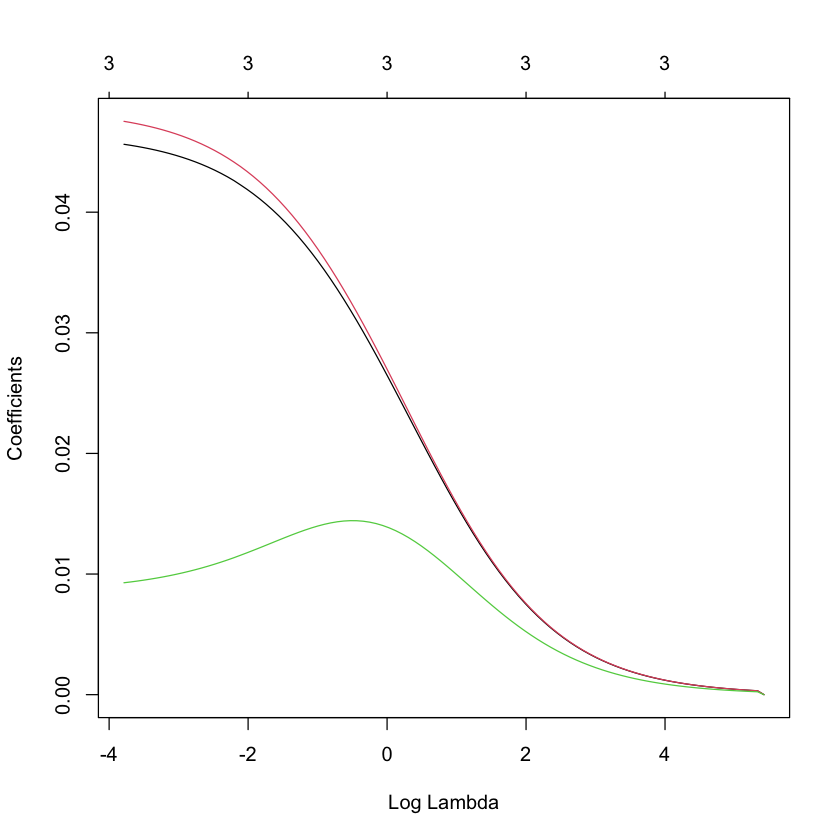

In [8]:
plot(ridge2, xvar = "lambda")

Notice none of the coefficients are forced to be zero, although they get close to it.

#### All the predictors

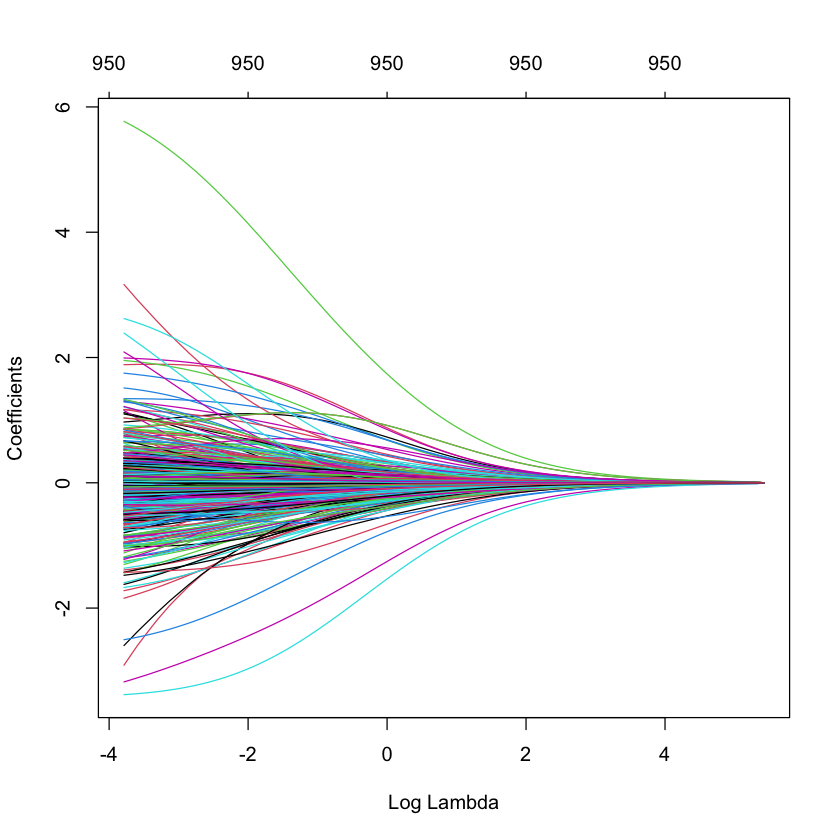

In [9]:
# Matrix of predictors (all but lnw_2016)
X <- as.matrix(nlsy  %>% select(-lnw_2016))

ridge_all <- glmnet(
  x = X,
  y = y,
  alpha = 0 #ridge
)

plot(ridge_all, xvar = "lambda")

## Lasso

Now let's fit lasso, which can be fit using `glmnet()` with alpha = 1 and seeks to minimize

$$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \sum_{j=1}^{p} |\beta_j|.
$$

Notice that the intercept is not penalized. 


### No penalty = OLS

In [10]:
lasso_no_pen <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1, #lasso
  lambda=0
)

In [11]:
lasso_no_pen$beta

3 x 1 sparse Matrix of class "dgCMatrix"
                 s0
educ     0.04648629
afqt     0.04853305
mom_educ 0.00856639

In [12]:
summary(lm(y~Xsmall))


Call:
lm(formula = y ~ Xsmall)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6805 -0.4221 -0.0270  0.3477  4.5395 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.071950   0.155975  13.284  < 2e-16 ***
Xsmalleduc     0.046496   0.010139   4.586 4.98e-06 ***
Xsmallafqt     0.048528   0.010056   4.826 1.56e-06 ***
Xsmallmom_educ 0.008564   0.011093   0.772     0.44    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8319 on 1262 degrees of freedom
Multiple R-squared:  0.08626,	Adjusted R-squared:  0.08409 
F-statistic: 39.71 on 3 and 1262 DF,  p-value: < 2.2e-16


### With Penalty

In [13]:
lasso_pen <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1, #lasso
  lambda=.02
)

In [14]:
lasso_pen$beta

3 x 1 sparse Matrix of class "dgCMatrix"
                 s0
educ     0.04323346
afqt     0.04523275
mom_educ 0.00359670

#### Larger Penalty

In [15]:
lasso_pen_large <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1, #lasso
  lambda=1e70
)

In [16]:
lasso_pen_large$beta

3 x 1 sparse Matrix of class "dgCMatrix"
         s0
educ      0
afqt      .
mom_educ  .

#### Various Penalties

In [17]:
lasso01 <- glmnet(
  x = Xsmall,
  y = y,
  alpha = 1 #lasso
)

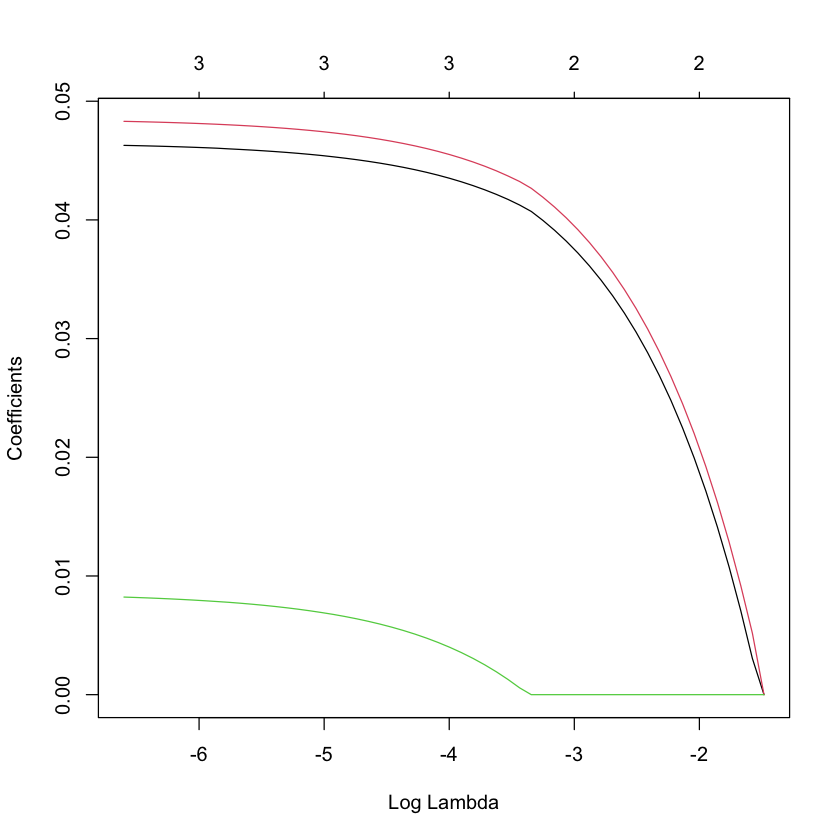

In [18]:
plot(lasso01, xvar = "lambda")

## Elastic Net 

$$
\min_{\beta_0,\beta} \frac{1}{N} \sum_{i=1}^{N} w_i l(y_i,\beta_0+\beta' x_i) + \lambda\left[(1-\alpha)\frac{1}{2}\|\beta\|_2^2 + \alpha \|\beta\|_1\right],
$$